In [43]:
import json
from pathlib import Path
from datetime import date
import base64
from getpass import getpass
import mimetypes

import streamlit as st
from IPython.display import Image
import instructor
from pydantic import BaseModel
from openai import OpenAI
import pandas as pd

In [ ]:
#Wprowadz klucz OPENAI
openai_key = getpass("Wprowadz swoj klucz OPENAI:")
openai_client = OpenAI(api_key=openai_key)



In [60]:
# Promompty
GENERALI_DEPOSIT = """
Wyciagnij wszystkie dane podane na screenshocie.
Dane przedstaw w formacie JSON
oczekuje nastepujacego przykladowego outputu:
{
"2024-11-14" : 123,123 PLN (tutaj zsumowana suma)

}
tylko dane bez zandych komentarzy
"""


CUMMULATED_PROMPT ="""
Twoim zadaniem bedzie rozpoznanie obrazu na podstawie slowa kluczowego. Na tej podstawie wykonasz odpowiednia instrukcje. Zaczynamy:

Jesli na obrazie zobaczysz napis 'Obligacje' wykonasz nastepujace polecenie: Na podstawie screenu pobierz dane na temat zainwestowanych obligacji. Kolumna odsteki pokazuje wypracowany zysk.
Kolumna liczba przedstawia zakupione obligacje. 1 obligacja to 100zl.
Dane przedstaw w formacie JSON w nastepujacym formacie
{
    "Obligacje": {
        "Wartosc": "30000PLN",
        "Zysk": "400PLN"
    }
}
 {"Wartosc": 30000PLN, "Zysk": 400PLN (zysk musi byc zsumowany z kazdej emisji)}

Jesli na obrazie bedzie napis Generali Investments wykonaj nastepujace polecenie:
Na podstawie screenu pobierz dane na temat ogolnej wartosci rachunku oraz bilansu.
Dane przedstaw w formacie JSON - bez komentarzy same dane w nastepujacym formacie:
{
    "GEnerali": {
        "Wartosc": "30000PLN",
        "Zysk": "400PLN"
    }
}

Jesli na obrazie zobaczysz nazwe BITCOIN wykonasz nastepujace polecenie:
Na podstawie screenu pobierzesz 2 wartosci liczbowe. 
Pierwsza widoczna i najwieksza zapisana bedzie jako wartosc - znajdziesz ja na gorze obrazu pogrubiona czacionka pod paskiem 'Szukaj'. 
Druga jako zysk (bedzie miala znaczek + z przodu).
Dane zapiszesz w formacie JSON: 
{
    "Kryptowaluty": {
        "Wartosc": "30000PLN", (- znajdziesz ja na gorze obrazu pogrubiona czacionka pod paskiem 'Szukaj')
        "Zysk": "400PLN"
    }
}

"""


In [5]:
RAW_IMAGE_FOLDER = Path("Images")
PROCESSED_IMAGES = RAW_IMAGE_FOLDER / "Processed"

In [7]:
for image_path in RAW_IMAGE_FOLDER.glob("*.png"):
    print(image_path)

Images/generali_dec_wplaty.png
Images/generali_dec_status.png


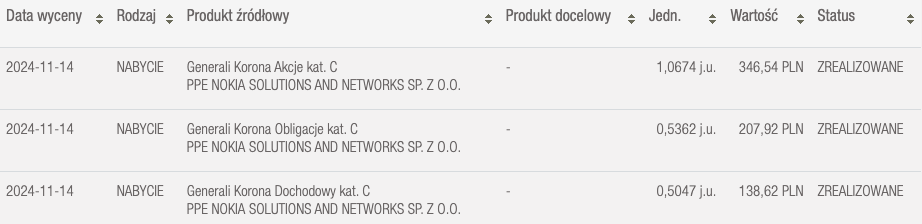

In [10]:
Image(RAW_IMAGE_FOLDER / "generali_dec_wplaty.png")

In [46]:
# Przygotowanie pliku do przeslania go do OpenAI - base64

image_path = RAW_IMAGE_FOLDER / "generali_dec_wplaty.png"
generali_status_path = RAW_IMAGE_FOLDER / "generali_status_with_logo.png"
obligacje_path = RAW_IMAGE_FOLDER / "obligacje.png"
revolut_path = RAW_IMAGE_FOLDER / "revolut.jpeg"

def prep_file_for_openai(image_path):
    # Sprawdzenie MIME typu na podstawie rozszerzenia pliku
    mime_type, _ = mimetypes.guess_type(image_path)
    
    # Obsługiwane typy obrazów
    supported_types = ["image/png", "image/jpeg"]
    
    # Sprawdzenie, czy typ MIME jest obsługiwany
    if mime_type not in supported_types:
        raise ValueError(f"Nieobsługiwany format obrazu: {mime_type}. Obsługiwane formaty to: {', '.join(supported_types)}")
    
    # Wczytanie obrazu i zakodowanie go w Base64
    with open(image_path, 'rb') as f:
        image_data = base64.b64encode(f.read()).decode('utf-8')
        return f"data:{mime_type};base64,{image_data}"

encoded_file = prep_file_for_openai(image_path=revolut_path)
print(encoded_file[:100])

data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQODwwQFxQYGBcUF


In [58]:
def generate_ai_response(image_path):

    response = openai_client.chat.completions.create(
        # model="gpt-4o",
        model="gpt-4o-mini",
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": CUMMULATED_PROMPT
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": prep_file_for_openai(image_path=image_path),
                            "detail": "high"
                        },
                    },
                ],
            }
        ],
    )


    return (response.choices[0].message.content)

In [ ]:
supported_extensions = ["*.png", "*.jpg", "*.jpeg"]


for pattern in supported_extensions:
    for image in RAW_IMAGE_FOLDER.glob(pattern):
        print(generate_ai_response(image))



        

```json
{
    "Generali": {
        "Wartosc": "49784,82PLN",
        "Zysk": "10013,35PLN"
    }
}
```
```json
{
    "Obligacje": {
        "Wartosc": "30485,50PLN",
        "Zysk": "485,50PLN"
    }
}
```
```json
{
    "Kryptowaluty": {
        "Wartosc": "21 547 zł",
        "Zysk": "+13 238,79 zł"
    }
}
```
